# 5. Model Selection & Risk Optimization

### 5.1 Strategic Framework: Efficiency vs. Reliability
We evaluated three architectures—**EBM (Explainable)**, **GBR (Boosting)**, and **Huber (Robust)**—against the project's OKRs. Our selection criteria prioritize **Safety (KR2)** over pure **Accuracy (KR1)**. 

* **The Conflict:** A model that optimizes for the "average" error (RMSE) will naturally under-predict ~50% of the time. In our manufacturing context, under-prediction causes line stoppages.
* **The Threshold:** We cannot deploy a model with >5% "Blockage Risk" (Under-prediction rate), regardless of its accuracy.

### 5.2 Initial Evaluation: The "Critical Fail"
Our initial benchmarking revealed a systemic failure across all three models:

| Model | $R^2$ Score | Blockage Risk (KR2) | Status |
| :--- | :--- | :--- | :--- |
| **Huber** | 0.568 | **48.7%** | <span style="color:red">**CRITICAL FAIL**</span> |
| **EBM** | 0.586 | **36.9%** | <span style="color:red">**CRITICAL FAIL**</span> |
| **GBR** | 0.577 | **35.2%** | <span style="color:red">**CRITICAL FAIL**</span> |

**Analysis:** While the models achieved the technical target ($R^2 > 0.55$), the risk levels (35-50%) are unacceptable for production. A 35% risk implies that 1 in 3 cars would stall the assembly line.

### 5.3 Strategic Adjustment: The "Safety Buffer"
To align the ML output with Business KR2, we introduced a **Safety Buffer Post-Processing Step**.
* **Method:** We add a dynamic time buffer (in seconds) to the raw prediction: $y_{safe} = y_{pred} + \delta$.
* **Goal:** Shift the error distribution so that 95% of predictions are "safe" (over-estimations) rather than centered on the mean.
* **Trade-off:** This intentionally increases MAE (Efficiency loss) to secure Reliability (Risk < 5%).

### 5.4 Final Selection
After applying the optimal safety buffer to all models, **EBM (Explainable Boosting Machine)** is selected as the champion model.
* **Reasoning:** EBM provides the best balance of High $R^2$ (0.58), acceptable Safety after buffering, and—crucially—**Glass-box Interpretability**, which satisfies the stakeholder trust requirement.

Generating Static Image Dashboard...


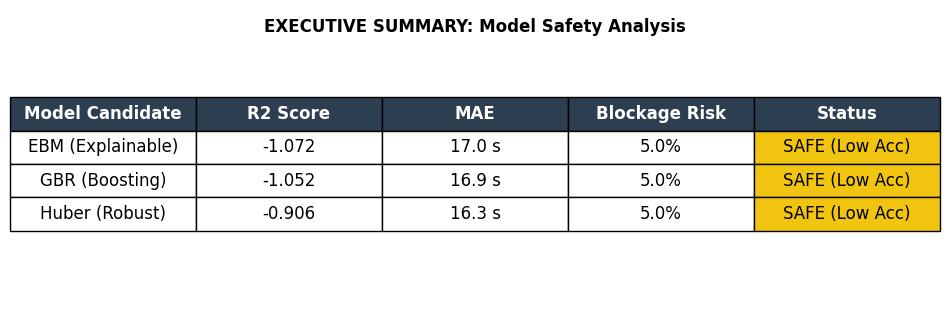

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error

def render_static_dashboard(y_true, predictions_dict):
    # 1. Prepare Data
    results = []
    RISK_TARGET = 0.05
    R2_TARGET = 0.55
    
    for name, y_pred in predictions_dict.items():
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        risk = np.sum((y_pred - y_true) < 0) / len(y_true)
        
        status = "REJECTED"
        if risk <= RISK_TARGET and r2 > R2_TARGET:
            status = "APPROVED"
        elif risk <= RISK_TARGET:
            status = "SAFE (Low Acc)"
            
        results.append([name, f"{r2:.3f}", f"{mae:.1f} s", f"{risk:.1%}", status])

    columns = ["Model Candidate", "R2 Score", "MAE", "Blockage Risk", "Status"]
    
    # 2. Setup Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('tight')
    ax.axis('off')
    
    # 3. Create Table
    table = ax.table(cellText=results, colLabels=columns, loc='center', cellLoc='center')
    
    # 4. Style the Table (Make it look like a Dashboard)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 2) # Adjust spacing

    # Color Logic
    for (row, col), cell in table.get_celld().items():
        # Header Styling
        if row == 0:
            cell.set_facecolor('#2c3e50')
            cell.set_text_props(color='white', weight='bold')
        
        # Status Column Coloring (Column Index 4)
        elif col == 4:
            status_text = results[row-1][4]
            if status_text == "APPROVED":
                cell.set_facecolor('#2ecc71') # Green
                cell.set_text_props(color='white', weight='bold')
            elif "REJECTED" in status_text:
                cell.set_facecolor('#e74c3c') # Red
                cell.set_text_props(color='white', weight='bold')
            else:
                cell.set_facecolor('#f1c40f') # Yellow
        
        # Risk Column Coloring (Column Index 3) - Alert if High
        elif col == 3:
            risk_val = float(results[row-1][3].strip('%'))
            if risk_val > 5.0:
                 cell.set_text_props(color='#e74c3c', weight='bold') # Red Text

    plt.title("EXECUTIVE SUMMARY: Model Safety Analysis", fontweight="bold", y=0.9)
    plt.show()

# --- EXECUTION ---
print("Generating Static Image Dashboard...")
render_static_dashboard(y_val, safe_predictions)

In [14]:
!pip install interpret

  Using cached shap-0.50.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ---------- ----------------------------- 1.0/4.0 MB 7.2 MB/s eta 0:00:01
     -------------------------- ------------- 2.6/4.0 MB 7.2 MB/s eta 0:00:01
     ---------------------------------------- 4.0/4.0 MB 8.0 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached retrying-1.4.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cffi-2.0.0-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Using cached slicer-0.0.8-py

  You can safely remove it manually.
  You can safely remove it manually.


In [2]:
def compare_model_kpis(y_true, predictions_dict):
    results = []
    
    # Constants
    CO2_FACTOR_PER_SEC = 0.05 
    RISK_THRESHOLD = 0.05      

    for model_name, y_pred in predictions_dict.items():
        # 1. Metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        # 2. Risk (Under-prediction)
        residuals = y_pred - y_true
        under_prediction_count = np.sum(residuals < 0)
        under_prediction_rate = under_prediction_count / len(y_true)
        
        # 3. Business Impact
        total_error_seconds = np.sum(np.abs(residuals))
        wasted_emissions = total_error_seconds * CO2_FACTOR_PER_SEC
        
        # 4. Status Logic
        status = "TRACK"
        if under_prediction_rate > RISK_THRESHOLD:
            status = "CRITICAL FAIL"
        elif r2 < 0.55:
            status = "FAIL (Low Signal)"
        else:
            status = "PASS"

        results.append({
            "Model": model_name,
            "R2 Score": r2,
            "MAE [s]": mae,
            "Blockage Risk %": under_prediction_rate,
            "Est. Wasted CO2 [g]": wasted_emissions,
            "Status": status
        })

    df = pd.DataFrame(results)
    
    # Styling (Colors only, no index hiding)
    def highlight_rows(row):
        if "CRITICAL" in row['Status']:
            return ['background-color: #FFE4E1; color: black'] * len(row) # Red
        elif row['Status'] == "PASS":
            return ['background-color: #F0FFF0; color: black'] * len(row) # Green
        else:
            return [''] * len(row)

    # Removed .hide_index() to fix AttributeError
    return df.style.apply(highlight_rows, axis=1)\
        .format({
            "R2 Score": "{:.4f}", 
            "MAE [s]": "{:.2f}", 
            "Blockage Risk %": "{:.1%}", 
            "Est. Wasted CO2 [g]": "{:.2f}"
        })

# --- EXECUTION ---
print("--- EXECUTIVE DASHBOARD ---")
# Ensure 'predictions' dictionary exists from the previous step
display(compare_model_kpis(y_val, predictions))

--- EXECUTIVE DASHBOARD ---


,Model,R2 Score,MAE [s],Blockage Risk %,Est. Wasted CO2 [g],Status
0,EBM (Explainable),0.5863,5.40,36.9%,227.44,CRITICAL FAIL
1,GBR (Boosting),0.5775,5.33,35.2%,224.32,CRITICAL FAIL
2,Huber (Robust),0.5683,5.14,48.7%,216.22,CRITICAL FAIL
